In [243]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

In [244]:
from PIL import Image

In [388]:
if not os.path.exists("image_names.txt"):
    names = open("image_names.txt", "w")
    img_names = os.listdir('../ALLSTIMULI')
    print('EXCLUDED:')
    for i in range(len(img_names)):
        if '2218506905' in img_names[i] or 'Data2' in img_names[i] \
            or 'Data3' in img_names[i] or 'Data4' in img_names[i] \
            or 'DS_' in img_names[i] or len(img_names[i])<=10\
            or 'i24622350' in img_names[i]:
            print(img_names[i])
        else:
            names.write(img_names[i][:-5]+'\n')
    names.close()
    
names = open("image_names.txt", "r")
img_names = names.readlines()
for i in range(len(img_names)):
    img_names[i]=img_names[i][:-1]

EXCLUDED:
.DS_Store
.svn
i24622350.jpeg
syntheticData2.jpeg
syntheticData3.jpeg
syntheticData4.jpeg
i2218506905.jpeg


In [265]:
loc_data_xy={}
for name in img_names:
    locpath_train = '../data/loc_data/train/' + name
    locpath_test = '../data/loc_data/test/' + name
    try:
        f = open(locpath_train,'rb')
    except:
        f = open(locpath_test,'rb')
    loc_dict = pickle.load(f)
    loc_data_xy[name] = np.array(loc_dict['barycenters'])

In [266]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    #plt.pause(0.001)  # pause a bit so that plots are updated

# Dataset class

In [267]:
class SaccadeLandmarksDataset(Dataset):
    """Saccade Landmarks dataset."""

    def __init__(self, loc_dict, img_dir, img_names, transform=None):
        """
        Args:
            loc_dict (dict): Dictonary containing saccade coordinates
            img_dir (string): Directory with all the images.
            img_names (lost): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.loc_dict = loc_dict
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.loc_dict)

    def __getitem__(self, idx):

        #img_name = os.listdir(self.img_dir)[idx+2]
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name + '.jpeg')
        image = io.imread(img_path)
        #name = img_name[:-5]
        landmarks = self.loc_dict[name]
        landmarks = np.array([landmarks])
        landmarks = landmarks.reshape(-1, 2) #.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'name':name}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Transforms

In [268]:
class RandomSaccadeTo(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        nb_sac = len(landmarks)
        sac_num =  np.random.randint(nb_sac)
        sac = landmarks[sac_num]
        N_X, N_Y = image.shape[:2]
        #img_color_sac = saccade_to(image, (N_X//2, N_Y//2), (sac[1], sac[0]))
        image_roll = np.copy(image)
        image_roll=np.roll(image_roll, N_X//2 - sac[1], axis=0)
        image_roll=np.roll(image_roll, N_Y//2 - sac[0], axis=1)
        return {'image':image_roll, 'pos':sac, 'name':sample['name']}

In [269]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_tens = sample['image'].transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image_tens), 'pos': sample['pos'],  'name':sample['name']}

### Adapted cropped pyramid (squeezed tensor)

In [270]:
from PYramid import cropped_pyramid

In [271]:
class CroppedPyramid(object):
    def __init__(self, width, base_levels, color=True, do_mask=False, verbose=False):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
    
    def __call__(self, sample):
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True)
        return{'img_crop':img_crop, 'level_size':level_size, 'pos':sample['pos'],  'name':sample['name']}
        
    

### LogGaborTransform

In [272]:
width=32
base_levels=2

In [273]:
from LogGabor import LogGabor
from PYramid import local_filter
from PYramid import get_K
from PYramid import log_gabor_transform

In [274]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2

pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)
K = get_K(width=width,
            n_sublevel = n_sublevel, 
          n_azimuth = n_azimuth, 
                  n_theta = n_theta,
                  n_phase = n_phase, 
                  r_min = width/6, 
                  r_max = width/3, 
                  log_density_ratio = 2, 
                  verbose=False)

In [275]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=True, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, sample):
        log_gabor_coeffs = log_gabor_transform(sample['img_crop'].unsqueeze(0), K)
        
        return{'img_gabor':log_gabor_coeffs, 'pos':sample['pos'],  'name':sample['name']}

### ComplexModulus

# Compose transforms
### transforms.Compose

In [276]:
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels)]) #, LogGaborTransform()])

In [278]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../ALLSTIMULI/',
                                          img_names=img_names,
                                          transform=composed_transform)

# Iterating through the dataset

In [279]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    for level in range(5,0,-1):
        plt.figure()
        images_batch = sample_batched['img_crop'][:,level,:,:,:]
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)).clip(0,255).astype('uint8'))

        plt.title('Batch from dataloader, level=' + str(level))


0 torch.Size([4, 6, 3, 32, 32])
0 ['i2221573154', 'i2264595399', 'i1079765858', 'i2186422800']
1 torch.Size([4, 6, 3, 32, 32])
1 ['istatic_submitted_saxena_chung_ng_nips2005_learningdepth_img_math14_p_313t0', 'i2130202677', 'i2083298845', 'i2084420834']
2 torch.Size([4, 6, 3, 32, 32])
2 ['i1460152281', 'istatic_outdoor_street_village_puigpunyent_mallorca_spain_IMG_4162', 'istatic_outdoor_urban_city_london_uk_IMG_8638', 'i245864757']
3 torch.Size([4, 6, 3, 32, 32])
3 ['i2170431637', 'i163125223', 'i1815291162', 'i1116123355']


<Figure size 432x288 with 0 Axes>

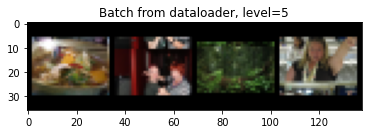

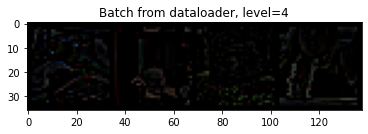

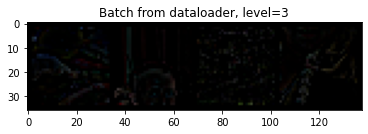

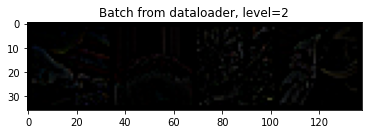

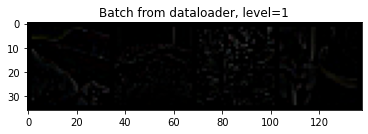

In [281]:
dataloader = DataLoader(saccade_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['img_crop'].size())
    print(i_batch, sample_batched['name'])
    if i_batch ==3 :
        plt.figure()
        show_landmarks_batch(sample_batched)  
        break
        

## Auto-encoder

In [294]:
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels), 
                               LogGaborTransform()])

In [295]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../ALLSTIMULI/',
                                          img_names=img_names,
                                          transform=composed_transform)

In [296]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2
n_levels = 6 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
n_eccentricity = 2
n_color = 3

In [297]:
print(n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase)

10368


In [298]:
class AutoEncoder(nn.Module):
    def __init__(self, in_chan = n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase, out_chan = 100):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(in_chan=in_chan, out_chan=out_chan)
        self.decoder = Decoder(in_chan=out_chan, out_chan=in_chan)

    def forward(self, x, **kargs):
        code = self.encoder(x)
        out = self.decoder(code)
        return out

In [299]:
class Encoder(nn.Module):
    """ Encoder
    """
    def __init__(self, in_chan, out_chan):
        super(Encoder, self).__init__()
        self.enc = nn.Linear(in_chan, out_chan)
            
    def forward(self, x):
        return self.enc(x)

In [300]:
class Decoder(nn.Module):
    """ Decoder
    """
    def __init__(self, in_chan, out_chan):
        super(Decoder, self).__init__()
        self.dec = nn.Linear(in_chan, out_chan)
            
    def forward(self, x):
        return self.dec(x)

In [316]:
autoenc = AutoEncoder()

In [317]:
autoenc.encoder.enc

Linear(in_features=10368, out_features=100, bias=True)

In [318]:
autoenc.encoder.enc.weight

Parameter containing:
tensor([[ 9.8183e-03, -8.3658e-05,  2.2434e-03,  ...,  9.6674e-03,
         -4.8732e-03,  9.0892e-03],
        [-5.1191e-03,  2.4229e-03, -1.0970e-03,  ...,  8.8751e-03,
          9.5212e-03, -8.7551e-04],
        [ 1.0437e-03, -8.6964e-03, -8.4476e-03,  ...,  1.7930e-03,
         -4.3990e-03,  8.5530e-04],
        ...,
        [-2.2671e-03, -4.0797e-03, -2.0592e-03,  ..., -4.3080e-03,
          5.0180e-03, -8.1869e-03],
        [-3.2950e-03,  3.9799e-03,  2.9749e-03,  ...,  5.7930e-03,
         -7.3848e-03, -8.6587e-03],
        [ 9.3710e-03, -9.3497e-03,  3.1777e-04,  ...,  9.7228e-03,
         -1.4614e-04,  2.0286e-03]], requires_grad=True)

In [319]:
autoenc.decoder.dec

Linear(in_features=100, out_features=10368, bias=True)

In [320]:
batch_size=15
n_epoch = 20
optimizer = optim.Adam(autoenc.parameters(), lr = 1e-4)
criterion = nn.MSELoss() #loss = criterion(outputs, inputs)

In [321]:
dataloader = DataLoader(saccade_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [ ]:
loss_list = []


In [326]:
n_epoch = 100
n_steps = 10
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs = data['img_gabor'].view(-1, n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase) #complete la dim du batch, taille vecteurs (tenseurs->vecteurs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoenc(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1)%n_steps == 0 :    # print every n_steps mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/n_steps))
            #.append
            loss_list.append(running_loss)
            running_loss = 0.0

print('Finished Training ')

[1,    10] loss: 3657.865
[1,    20] loss: 3918.267
[1,    30] loss: 3799.165
[1,    40] loss: 3958.248
[1,    50] loss: 3452.569
[1,    60] loss: 3742.352
[2,    10] loss: 3599.285
[2,    20] loss: 3837.463
[2,    30] loss: 3457.328
[2,    40] loss: 3387.009
[2,    50] loss: 3818.316
[2,    60] loss: 3604.820
[3,    10] loss: 3876.112
[3,    20] loss: 3722.771
[3,    30] loss: 3622.183
[3,    40] loss: 3666.552
[3,    50] loss: 3625.310
[3,    60] loss: 3858.392
[4,    10] loss: 3780.775
[4,    20] loss: 3522.560
[4,    30] loss: 3730.427
[4,    40] loss: 3247.750
[4,    50] loss: 3744.285
[4,    60] loss: 3709.112
[5,    10] loss: 3679.684
[5,    20] loss: 3724.522
[5,    30] loss: 3662.189
[5,    40] loss: 3384.132
[5,    50] loss: 3650.590
[5,    60] loss: 3398.137
[6,    10] loss: 3516.967
[6,    20] loss: 3565.405
[6,    30] loss: 3764.044
[6,    40] loss: 3615.398
[6,    50] loss: 3850.529
[6,    60] loss: 3747.270
[7,    10] loss: 3564.909
[7,    20] loss: 3672.353
[7,    30] l

[52,    10] loss: 3145.075
[52,    20] loss: 2943.705
[52,    30] loss: 2935.761
[52,    40] loss: 3050.507
[52,    50] loss: 3183.785
[52,    60] loss: 2894.650
[53,    10] loss: 3096.305
[53,    20] loss: 2797.365
[53,    30] loss: 3156.625
[53,    40] loss: 3075.903
[53,    50] loss: 2818.756
[53,    60] loss: 2978.995
[54,    10] loss: 3056.318
[54,    20] loss: 2911.770
[54,    30] loss: 3031.361
[54,    40] loss: 3055.206
[54,    50] loss: 2749.830
[54,    60] loss: 2991.111
[55,    10] loss: 2875.228
[55,    20] loss: 3190.991
[55,    30] loss: 2801.679
[55,    40] loss: 3202.764
[55,    50] loss: 2786.558
[55,    60] loss: 2849.756
[56,    10] loss: 3066.309
[56,    20] loss: 3090.408
[56,    30] loss: 2739.143
[56,    40] loss: 2947.039
[56,    50] loss: 2974.370
[56,    60] loss: 2980.104
[57,    10] loss: 3062.709
[57,    20] loss: 3159.600
[57,    30] loss: 2934.321
[57,    40] loss: 3115.402
[57,    50] loss: 2917.867
[57,    60] loss: 2924.588
[58,    10] loss: 3071.918
[

Text(0.5, 0, '# batch')

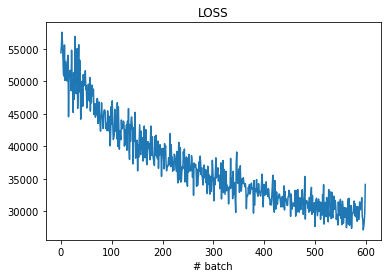

In [380]:
plt.plot(loss_list)
plt.title('LOSS')
plt.xlabel('# batch')

## Encoding and decoding

In [401]:
locpath = '../ALLSTIMULI/' + img_names[0] + '.jpeg'
img_orig = Image.open(locpath)
img_tens = torch.Tensor(np.array(img_orig)[None,...]).permute(0,3,1,2)

In [402]:
img_crop = cropped_pyramid(img_tens, color=True, do_mask=True,verbose=True)[0]

Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [403]:
log_gabor_coeffs = log_gabor_transform(img_crop, K)
log_gabor_coeffs.shape

torch.Size([1, 6, 3, 2, 12, 12, 2])

In [404]:
encoder_input = log_gabor_coeffs.view(-1, n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase)

In [405]:
code = autoenc.encoder.enc(encoder_input)

Text(0.5, 1.0, 'Image embedding')

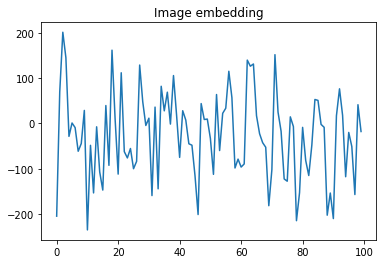

In [406]:
plt.plot(code.detach().numpy().flatten())
plt.title('Image embedding')

In [407]:
encoder_output = autoenc.decoder.dec(code)

In [408]:
log_gabor_coeffs_rec = encoder_output.view(-1, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase)

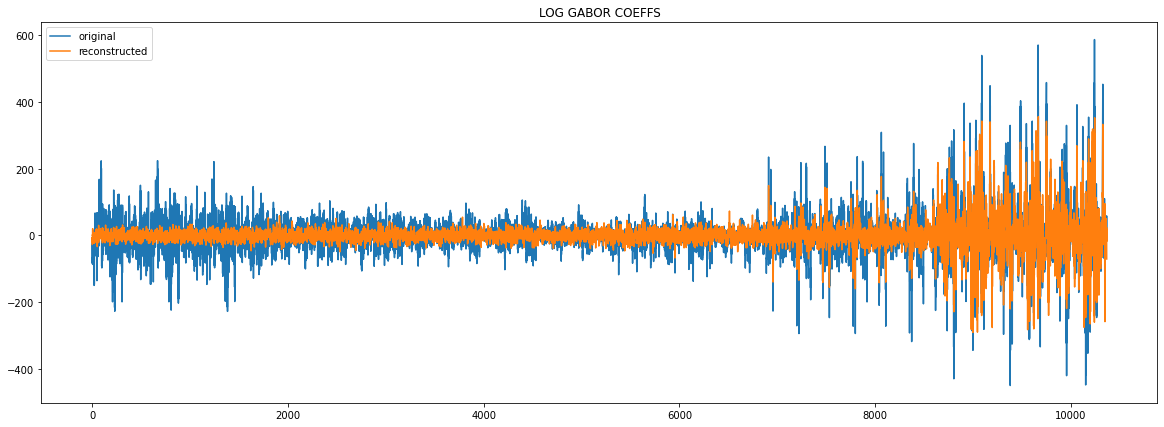

In [409]:
plt.figure(figsize=(20,7))
plt.plot(log_gabor_coeffs.numpy().flatten(), label = 'original')
plt.plot(log_gabor_coeffs_rec.detach().numpy().flatten(), label = 'reconstructed')
plt.title('LOG GABOR COEFFS')
plt.legend()

In [426]:
def tensor_pyramid_display(img_pyr_tens):
    fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
    img_aff = img_pyr_tens.permute(0,1,3,4,2).detach().numpy()
    for i_level, ax in enumerate(axs):
        if i_level < n_levels-1:
            bias = 128
        else:
            bias = 0
        ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
        ax.plot([width/2], [width/2], 'r+', ms=32);
    print('Tensor shape=', img_rec.shape) 
    return axs

## Reconstruction tests

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([576, 1024])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])


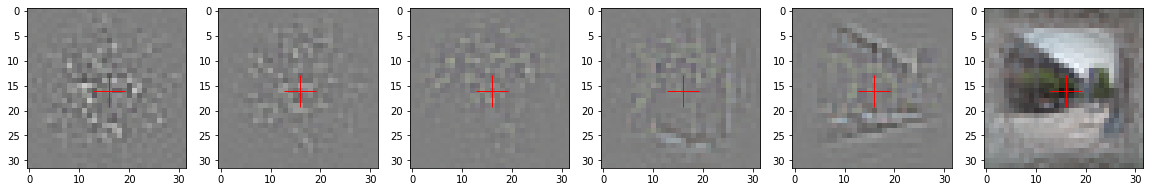

In [428]:
from PYramid import get_K_inv
K_inv = get_K_inv(K)
img_rec=inverse_gabor(log_gabor_coeffs.detach(), K_inv)
axs = tensor_pyramid_display(img_rec)

Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])


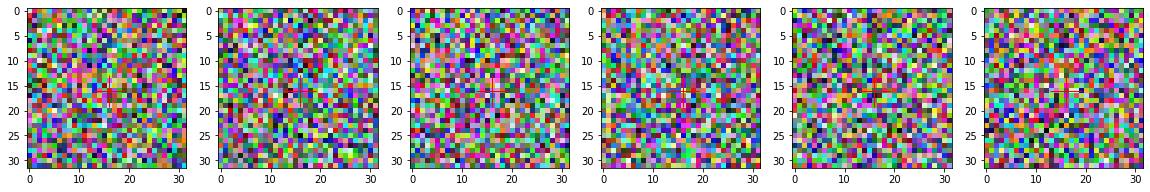

In [429]:
img_rec_rec=inverse_gabor(log_gabor_coeffs_rec.detach(), K_inv)
axs = tensor_pyramid_display(img_rec_rec)

## Pseudo inverse regularization test

Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([1, 6, 3, 32, 32])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])
Tenso

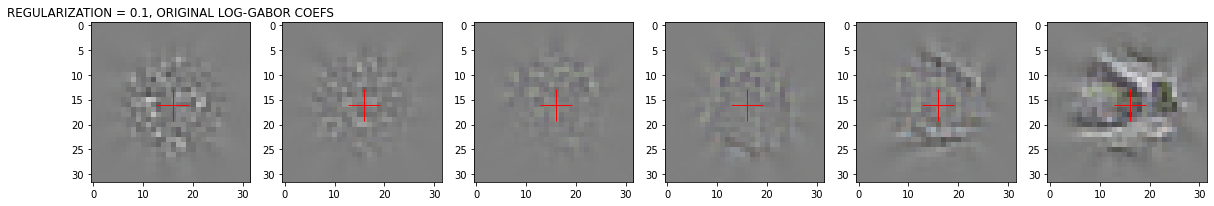

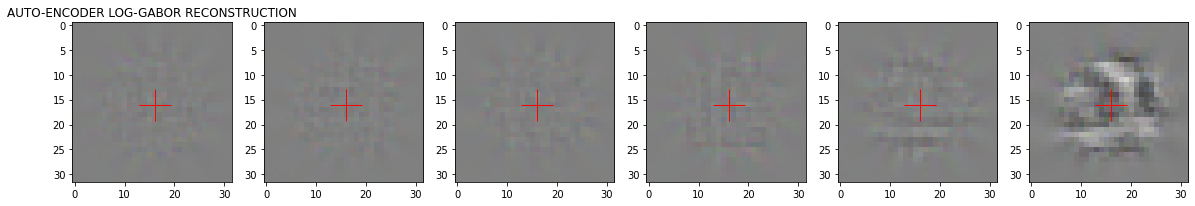

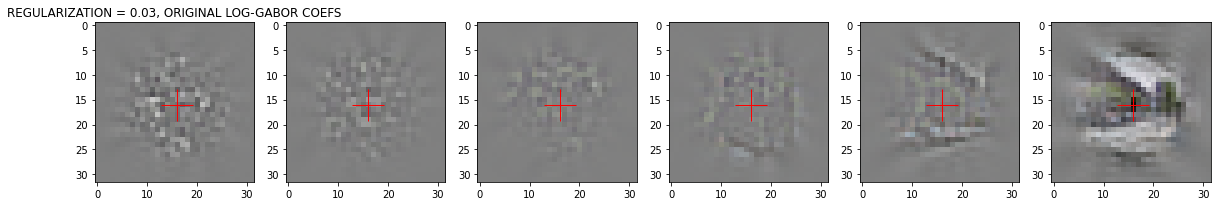

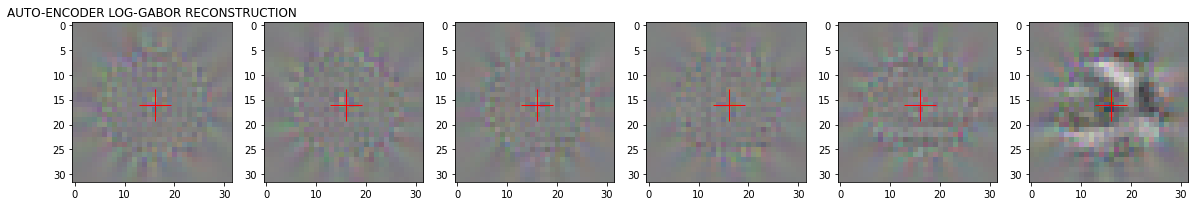

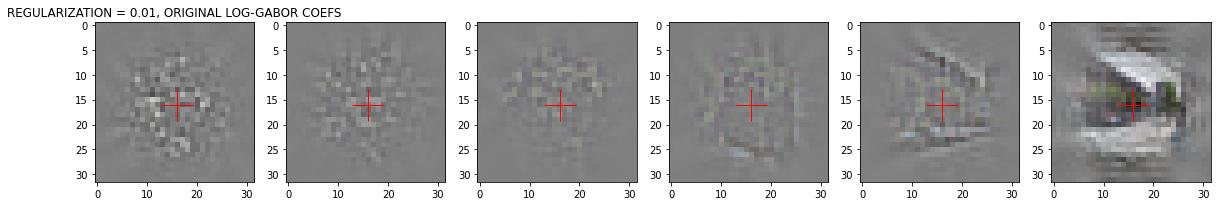

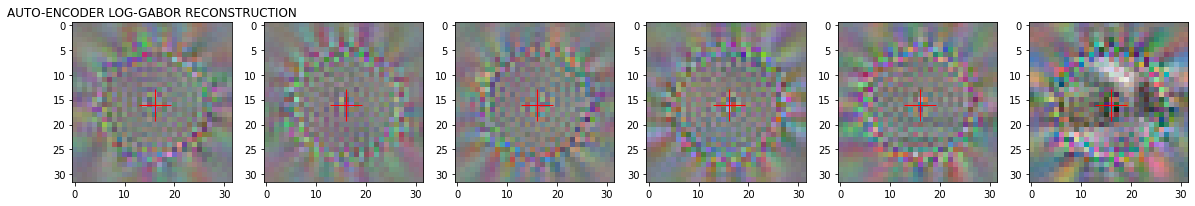

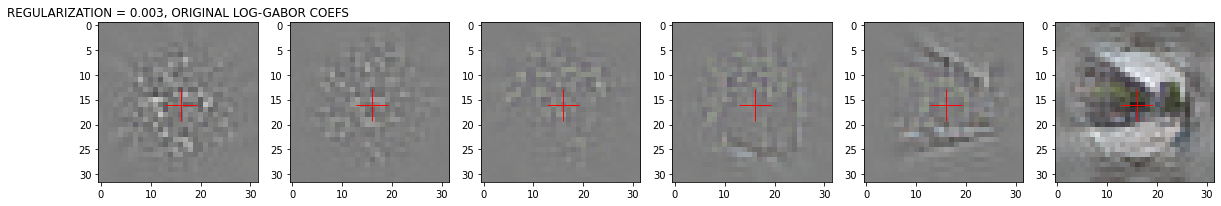

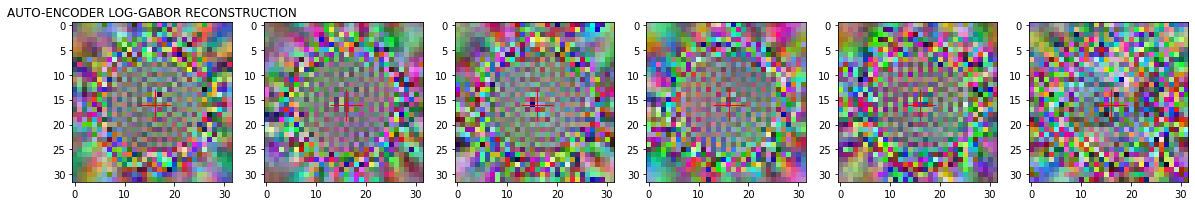

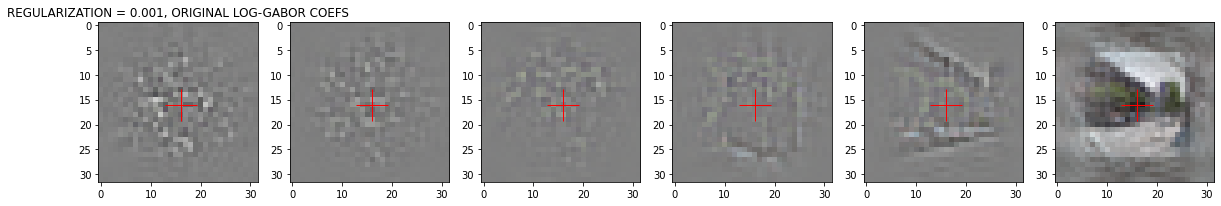

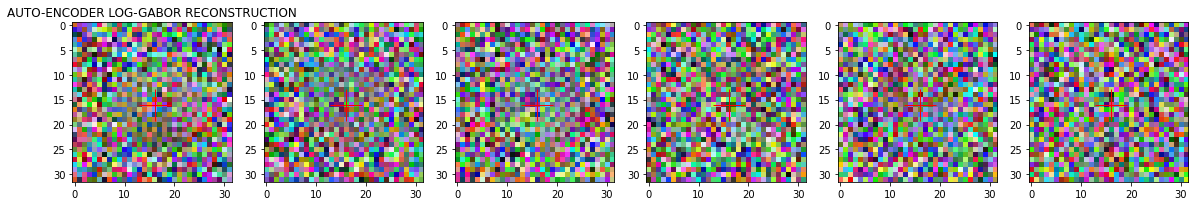

In [434]:
for rcond in 0.1, 0.03, 0.01, 0.003, 0.001:
    K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    print('Reshaped filter tensor=', K_.shape)
    K_inv_test = torch.pinverse(K_, rcond=rcond) 
    print('Tensor shape=', K_inv.shape)
    K_inv_test =K_inv_test.reshape(n_sublevel, n_azimuth, n_theta, n_phase, width, width)
    img_rec_test = inverse_gabor(log_gabor_coeffs.detach(), K_inv_test)
    axs = tensor_pyramid_display(img_rec_test)
    axs[0].set_title('REGULARIZATION = '+str(rcond)+', ORIGINAL LOG-GABOR COEFS')
    img_rec_rec_test =inverse_gabor(log_gabor_coeffs_rec.detach(), K_inv_test)
    axs = tensor_pyramid_display(img_rec_rec_test)
    axs[0].set_title('AUTO-ENCODER LOG-GABOR RECONSTRUCTION')    